In [12]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import random
from src.shadow_learn import ShadowedSetEstimator
from src.datasets import load_synthetic_dataset_with_proba
from src.model_selection import grid_search
import plotly.graph_objects as go

In [2]:
target = 'red' # 0 = red, 1 = blue
red_anomaly_proba = 0.0 
blue_anomaly_proba = 0.1
both_anomaly_proba = None
random_state = 42
random.seed(random_state)

In [3]:
X, y = make_circles(n_samples=200, factor=.3, noise=.05, random_state=random_state)
pd.Series(y).value_counts()

1    100
0    100
dtype: int64

In [4]:
new_y = []
for i in range(len(y)):
    # red dots
    if y[i] == 0:
        r = random.uniform(0,1)
        if r <= blue_anomaly_proba:
            new_y.append(1)
        elif both_anomaly_proba is not None:
            if r <= both_anomaly_proba:
                new_y.append(1)
        else:
            new_y.append(0)
    # blue dots
    elif y[i] == 1:
        r = random.uniform(0,1)
        if r <= red_anomaly_proba:
            new_y.append(0)
        elif both_anomaly_proba is not None:
            if r <= both_anomaly_proba:
                new_y.append(0)
        else:
            new_y.append(1)

In [5]:
y = np.array(new_y)
pd.Series(y).value_counts()

1    114
0     86
dtype: int64

Text(0, 0.5, '$x_2$')

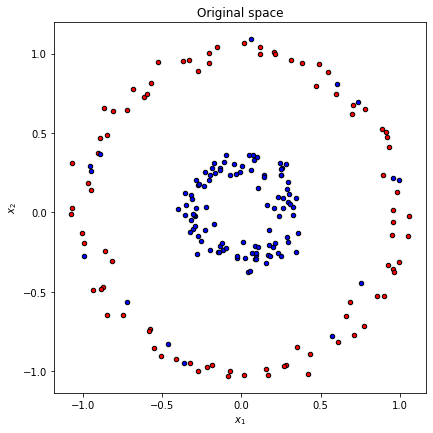

In [6]:
plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [7]:
X, y, data_labels, target = load_synthetic_dataset_with_proba(
    target='red',
    red_anomaly_proba = 0.0, 
    blue_anomaly_proba = 0.1
)
pd.Series(y).value_counts()

-1    114
 1     86
dtype: int64

In [8]:
log = False
estimator = ShadowedSetEstimator(solver='gurobi-two-phases')
dataset_loader = lambda: load_synthetic_dataset_with_proba(
    target='red',
    red_anomaly_proba = 0.0, 
    blue_anomaly_proba = 0.1
)
C0_range = np.concatenate((np.logspace(-1, 0, 0), [0.1]))
C1_range = np.concatenate((np.logspace(-1, 0, 0), [0.177828]))
sigma_range = np.concatenate((np.logspace(-1, 1, 0), [0.5]))
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}

In [9]:
gs = grid_search(dataset_loader, estimator, 'conservative', 
                 param_grid, log=log)
gs

***** Split n. 0
Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   19.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   40.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  2.6min


Using license file C:\Users\gabri\gurobi.lic
Academic license - for non-commercial use only


[Parallel(n_jobs=2)]: Done 2160 out of 2160 | elapsed:  3.1min finished


mean_fit_time                                                 0.148964
std_fit_time                                                0.00147711
mean_score_time                                             0.00781713
std_score_time                                             0.000437098
param_C0                                                           0.1
param_C1                                                      0.177828
param_sigma                                                        0.5
params               {'C0': 0.1, 'C1': 0.1778279410038923, 'sigma':...
split0_test_score                                             0.857143
split1_test_score                                             0.714286
split2_test_score                                             0.857143
split3_test_score                                             0.857143
split4_test_score                                             0.714286
split5_test_score                                             0.928571
split6

{'best_gs': GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
              estimator=ShadowedSetEstimator(), n_jobs=2,
              param_grid={'C0': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ,
        0.2       ]),
                          'C1': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ,
        0.2       ]),
                          'sigma': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ,
         0.5       ])},
              scoring=make_scorer(conservative_score), verbose=1),
 'scores': (0.8333333333333334, 0.0, array([0.83333333])),
 'sets': {'X_trains': [array([[-0.19622734,  0.23285908],
          [-0.31385896, -0.04789331],
          [-0.1668936 ,  0.24953319],
          [ 0.24659584,  0.31232139],
          [ 0.7511687 , -0.44752156],
          [-0.28849688,  0.02669105],
          [-0.89005318,  0.370912  ],
          [ 0.32618992,  0.03193248],
          [ 0.089793  , -0.271

In [10]:
best_estimator = gs['best_gs'].best_estimator_
best_estimator

ShadowedSetEstimator(C1=0.1778279410038923, sigma=0.5)

In [11]:
X_train = gs['sets']['X_trains'][0]
X_test = gs['sets']['X_tests'][0]
y_train = gs['sets']['y_trains'][0]
y_test = gs['sets']['y_tests'][0]